# XGBoost to predict discharge disability: Feature selection
(using stratified 5-fold cross validation)

### Plain English summary
Machine learning algorithms (such as XGBoost) were devised to deal with enormous and complex datasets, with the approach that the more data that you can throw at them, the better, and let the algorithms work it out themselves.

However this approach can make it tricky to be able to explain a coherent story about how the models are working, the relationships that they have found, and how they have made their predictions.

Our machine learning work has taken on an additional focus - to make our work as explainable as possible. Both in terms of being able to explain how the models have arrived at their outcome, and in the ease at which we can disseminate our work to a wider audience. For us to have explainable models we want to have a balance between model complexity and model accuracy in order to be able to explain our models, whilst maintaining model performance.

In this notebook we create a model to predict the disability level of a patient who had a stroke, at discharge from inpatient care. Disability is recorded in the SSNAP dataset using the modified Rankin Scale (mRS). The scale runs from 0–6, running from perfect health without symptoms to death. The model returns a probability score of the patient being in each of these seven mRS levels. This is known as a multiclass classification problem. The patient is predicted to have the mRS level with the highest probability.

We train a model using just a single input feature, chosen as the feature that gave the model it's best performance (based on ROCAUC). The single feature that gave the best model performance was "prior disability". Fixing this feature in the model, we repeated the process to chose the next single feature to add to the model. The best single feature to include next was "Stroke severity". We repeated this process, choosing the next feature to add to the model until 25 features were included (it was limited to 25 features for computational time purposes).

We found that with 14 features the performance plateaued at ROCAUC 0.8189 (this exceeds the performance with all 58 features by 0.0011). These 14 features are:

Feature  1: prior_disability, AUC: 0.687\
Feature  2: stroke_severity, AUC: 0.770\
Feature  3: stroke_team, AUC: 0.800\
Feature  4: age, AUC: 0.806\
Feature  5: year, AUC: 0.811\
Feature  6: nihss_arrival_loc, AUC: 0.814\
Feature  7: scan_to_thrombolysis_time, AUC: 0.816\
Feature  8: thrombolysis_no_but_improving, AUC: 0.817\
Feature  9: nihss_arrival_best_language, AUC: 0.818\
Feature 10: new_afib_diagnosis, AUC: 0.818\
Feature 11: nihss_arrival_sensory, AUC: 0.819\
Feature 12: atrial_fibrillation, AUC: 0.819\
Feature 13: nihss_arrival_facial_palsy, AUC: 0.819\
Feature 14: thrombolysis_no_but_other_medical, AUC: 0.819\

A model with the first eight features is able to provide 99.96% of the accuracy obtained when all 58 features are used (ROCAUC: 0.817804 vs 0.81780). The eight features are largely independent of each other (refer to notebook check correlation between selected features to confirm this).

A model with 9 features matched the performance of the model with all of the features (ROCAUC 0.81800 vs 0.81780). The best performance (when looking up to selecting 25 features) came with 23 features (ROCAUC: 0.81987), but we're at such small margins of improvements after four features (within 1% of the full model).

We have done some further analysis on feature selection. Those notebooks informed our choice to train future models using these seven features (reasoning given in the bottom markdown cell):
* prior_disability
* stroke_severity
* stroke_team
* age
* onset_to_thrombolysis_time
* any_afib_diagnosis
* precise_onset_known

A model with these 7 features has a performance of ROCAUC 0.809 [notebook 040]. And are largely independant of each other (refer to notebook 030 to check the correlation between these features to confirm this).

This is not saying that these are the 7 most important features, as another highly correlated feature may also have been important, but it is now not needed to be included in this model that is being used for predictive purposes.

### Model and data
XGBoost models were trained on stratified k-fold cross-validation data. The full dataset contains 58 features that describe the patient (in terms of their clinical characteristics, the stroke pathway, and the stroke team that they attended). Features to be included in the model were sequentially selected as the single best feature to add to the model in terms of performance from the area under the receiver operating characteristic (ROC AUC) curve. When included, the hospital and weekday feature are included as a one-hot encoded feature.

### Aims
* Select up to 25 features (from the full set of 58 features) using forward feature selection. Features are selected sequentially (using the greedy approach), choosing the feature that leads to most improvement in ROC AUC score.
* Decide on the number of features to include in future models

### Observations
* Eight features are able to provide a ROC AUC of 0.818 (0.81780 with all features). These features are also largely independent of each other.
* Our best model with 1, 2, 10 & 25 features had a ROC AUC of 0.687, 0.770, 0.818 & 0.820.
* The AUC exceeds the all feature performance with fewer features. Even though the gains in performance are becomming negligable with additional features, the performance has yet to peak and go down when choosing up to 25 features.

### Follow up work
* Calculate the correlation between the first 10 selected features [see notebook 030]
* Is it reasonable to replace scan_to_thrombolysis with onset_to_thrombolysis time? Calculate the ROCAUC using the 4 features (prior disability, stroke severity, age, stroke team) plus i. scan to IVT, or ii. arrival the IVT [see notebook]
* Look at alternative models that include some of the other features as well as the "simple 5". (such as year, thrombolysis_no_but_improving, new_afib_diagnosis, atrial_fibrillation). What do these features contribute to the patients chance of death (their SHAP value for output for mRS 6) [see notebook]
* Have a model with the 4 features along with either 1) stroke severity, or 2) individual NIHSS component features (confirm whether if include stroke severity, then not need to include the components) [see notebook]

## Import libraries

In [5]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

from sklearn.metrics import confusion_matrix

#import seaborn as sns

from sklearn.metrics import roc_auc_score

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [6]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    notebook: str = '020_'

paths = Paths()

Create output folders if needed

In [ ]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [4]:
train_data, test_data = [], []

for k in range(5):

    filename = os.path.join(paths.data_read_path, 
                                ('03_train_' + str(k) + '.csv'))
    train_data.append(pd.read_csv(filename))
    filename = os.path.join(paths.data_read_path, 
                                ('03_test_' + str(k) + '.csv'))
    test_data.append(pd.read_csv(filename))
    if 'id' in train_data[k].columns: train_data[k].drop(['id'],axis=1,
                                                         inplace=True)
    if 'id' in test_data[k].columns: test_data[k].drop(['id'],axis=1,
                                                       inplace=True)

Get list of features

In [5]:
features = list(train_data[0])
print(f"There are {len(features)} features")

There are 58 features


## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [6]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [7]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

for feature, prefix in zip(features_to_one_hot, list_prefix):
    for k_fold in range(5):
        train_data[k_fold] = convert_feature_to_one_hot(train_data[k_fold], feature, prefix)
        test_data[k_fold] = convert_feature_to_one_hot(test_data[k_fold], feature, prefix)

## Fit XGBoost model

Train model with all features (as comparison)

In [8]:
r_square_kfold = []
roc_auc_ovr_kfold = []
accuracy_kfold = []
error_within_one_kfold = []
feature_importance_kfold = []
y_probs_kfold = []
y_pred_kfold = []
model_kfold = []

# Loop through k folds
for k_fold in range(5):

    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]

    # Get X and y
    X_train = train.drop('discharge_disability', axis=1)
    X_test = test.drop('discharge_disability', axis=1)
    y_train = train['discharge_disability']
    y_test = test['discharge_disability']

    # One hot encode categorical features
    for feature, prefix in zip(features_to_one_hot, list_prefix):
        X_train = convert_feature_to_one_hot(X_train, feature, prefix)
        X_test = convert_feature_to_one_hot(X_test, feature, prefix)

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)
    model_kfold.append(model)
    
    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_kfold.append(y_probs)

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_kfold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_kfold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_kfold.append(feature_importance)

# Get average result from all k-fold splits
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)
accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, AUC: {roc_auc_ovr_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(roc_auc_ovr_kfold):0.3f})')

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(error_within_one_kfold):0.3f})')

All features, AUC: 0.818 (std across 5 kfolds: 0.001)
All features, accuracy: 0.440 (std across 5 kfolds: 0.002)
All features, accuracy within one: 0.760 (std across 5 kfolds: 0.002)


Check that the five ROC AUC are not identical (to give the stddev 0)

In [9]:
roc_auc_ovr_kfold

[0.8175221016339,
 0.8187539196652739,
 0.81747845732837,
 0.8169080263453535,
 0.8183590503336651]

## Fit XGBoost model

Loop through each feature in turn and train an XGBoost model with that feature added to the dataset (for each k-fold split). Choose the single best feature to add to the model in terms of performance from the ROC AUC using one vs rest (mean of the k-fold splits).

Repeat until 25 features have been selected.

In [10]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_by_feature_number_kfold = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(train_data[0].drop('discharge_disability', axis=1))
number_of_features = len(available_features)

# Loop through number of features
for i in range (25):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up a list to hold AUC results for this feature for each kfold
        feature_roc_auc_ovr_kfold = []
        
        # Loop through k folds
        for k_fold in range(5):

            # Get k fold split
            train = train_data[k_fold]
            test = test_data[k_fold]

            # Get X and y
            X_train = train.drop('discharge_disability', axis=1)
            X_test = test.drop('discharge_disability', axis=1)
            y_train = train['discharge_disability']
            y_test = test['discharge_disability']
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]

            # One hot encode categorical features
            for cat_feature, prefix in zip(features_to_one_hot, list_prefix):
                if cat_feature in features_to_use:
                    X_train = convert_feature_to_one_hot(X_train, cat_feature, prefix)
                    X_test = convert_feature_to_one_hot(X_test, cat_feature, prefix)

            # Define model
            model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

            # Fit model
            model.fit(X_train, y_train)

            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)
            
            # Calculate ROC AUC for multiclass models, using One vs Rest
            feature_roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
            feature_roc_auc_ovr_kfold.append(feature_roc_auc_ovr)

        
        # Get average result from all k-fold splits
        feature_auc_mean = np.mean(feature_roc_auc_ovr_kfold)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc_mean > best_result:
            best_result = feature_auc_mean
            best_result_kfold = feature_roc_auc_ovr_kfold
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_by_feature_number_kfold.append(best_result_kfold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: prior_disability, AUC: 0.687
Feature  2: stroke_severity, AUC: 0.770
Feature  3: stroke_team, AUC: 0.800
Feature  4: age, AUC: 0.806
Feature  5: year, AUC: 0.811
Feature  6: nihss_arrival_loc, AUC: 0.814
Feature  7: scan_to_thrombolysis_time, AUC: 0.816
Feature  8: thrombolysis_no_but_improving, AUC: 0.817
Feature  9: nihss_arrival_best_language, AUC: 0.818
Feature 10: new_afib_diagnosis, AUC: 0.818
Feature 11: nihss_arrival_sensory, AUC: 0.819
Feature 12: atrial_fibrillation, AUC: 0.819
Feature 13: nihss_arrival_facial_palsy, AUC: 0.819
Feature 14: thrombolysis_no_but_other_medical, AUC: 0.819
Feature 15: infarction, AUC: 0.819
Feature 16: arrive_by_ambulance, AUC: 0.819
Feature 17: nihss_arrival_motor_arm_left, AUC: 0.819
Feature 18: thrombolysis_no_but_comorbidity, AUC: 0.819
Feature 19: nihss_arrival_loc_questions, AUC: 0.819
Feature 20: nihss_arrival_motor_arm_right, AUC: 0.819
Feature 21: nihss_arrival_best_gaze, AUC: 0.820
Feature 22: thrombolysis_no_but_too_mild_sev

Create a dataframe that contains the chosen features, and their mean ROC AUC across the k-fold splits, and the standard deviation.

In [11]:
results = pd.DataFrame()
results['number_features'] = range(1, len(chosen_features)+1)
results['feature'] = chosen_features
results['AUC'] = roc_auc_by_feature_number
results['AUC_Std'] = [np.std(auc) for auc in roc_auc_by_feature_number_kfold]
results

,number_features,feature,AUC,AUC_Std
0,1,prior_disability,0.686897,0.000958
1,2,stroke_severity,0.770089,0.000818
2,3,stroke_team,0.800489,0.000667
3,4,age,0.806065,0.000578
4,5,year,0.811270,0.000544
5,6,nihss_arrival_loc,0.814141,0.000597
6,7,scan_to_thrombolysis_time,0.815526,0.000585
7,8,thrombolysis_no_but_improving,0.816601,0.000608
8,9,nihss_arrival_best_language,0.817514,0.000576
9,10,new_afib_diagnosis,0.817997,0.000763


In [12]:
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_selection.csv'))

results.to_csv(filename, index=False)

## Plot the results
Plot a line graph showing the change in mean ROC AUC (across k-fold splits) for the number of features chosen in the model.

In [13]:
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_selection.csv'))

results = pd.read_csv(filename)

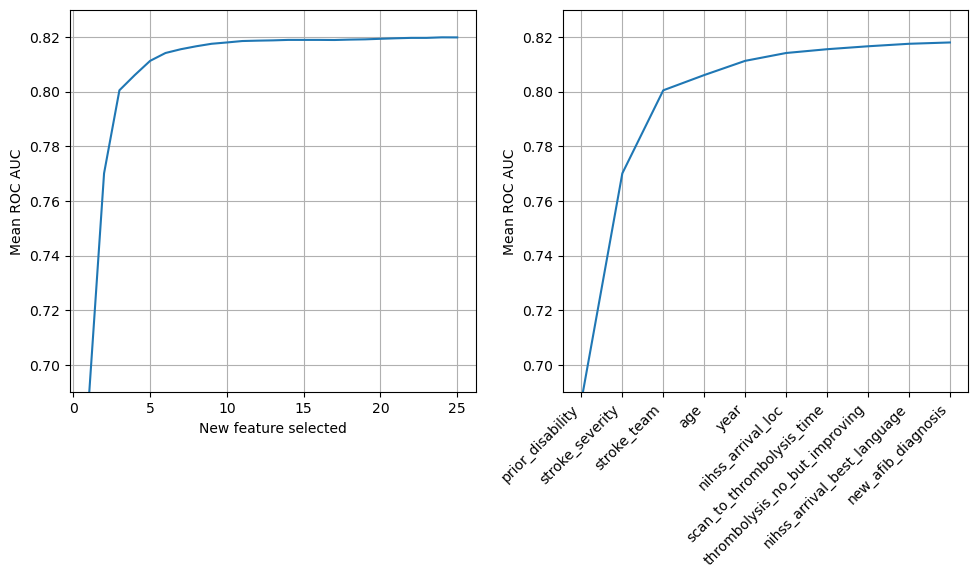

In [14]:
features_to_show = 10

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1.plot(results['number_features'], results['AUC'])
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Mean ROC AUC')
ax1.set_ylim(0.69, 0.83)
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results['feature'][:features_to_show],
         results['AUC'][:features_to_show])
xlabels = list(results['feature'])
xlabels = xlabels[:features_to_show]
ax2.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set_ylabel('Mean ROC AUC')
ax1.set_xlabel('New feature selected')
ax2.set_ylim(0.69, 0.83)
ax2.grid()

plt.tight_layout(pad=1.5)

filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_selection.jpg'))
plt.savefig(filename, dpi=300)
plt.show()

Save dictionary as a json (to be read in and used by the other notebooks).

In [2]:
feature_name_dict = {
    "prior_disability": "Prior disability level",
    "stroke_severity": "Stroke severity",
    "stroke_team": "Stroke team",
    "age": "Age",
    "year": "Year",
    "nihss_arrival_loc": "NIHSS arrival loc",
    "scan_to_thrombolysis_time": "Scan-to-thrombolysis time",
    "thrombolysis_no_but_improving": "Thrombolysis-No but improving",
    "nihss_arrival_motor_arm_left": "NIHSS arrival motor arm left",
    "nihss_arrival_best_gaze": "NIHSS arrival best gaze",
    "nihss_arrival_motor_arm_right": "NIHSS arrival motor arm right",
    "male": "Male",
    "month": "Month",
    "nihss_arrival_dysarthria": "NIHSS arrival dysarthria",
    "infarction": "Infarction",
    "arrive_by_ambulance": "Arrive by ambulance",
    "thrombolysis_no_but_too_mild_severe": "Thrombolysis-No but too mild severe",
    "diabetes": "Diabetes",
    "thrombolysis_no_but_haemorrhagic": "Thrombolysis-No but haemorrhagic",
    "nihss_arrival_motor_leg_right": "NIHSS arrival motor leg right",
    "nihss_arrival_sensory": "NIHSS arrival sensory",
    "afib_antiplatelet": "AFIB antiplatelet",
    "thrombolysis_no_but_other_medical": "Thrombolysis-No but other medical",
    "nihss_arrival_best_language": "NIHSS arrival best language",
    "congestive_heart_failure": "Congestive heart failure",
    "new_afib_diagnosis": "New atrial fibrillation diagnosis",
    "atrial_fibrillation": "Existing atrial fibrillation diagnosis",
    "nihss_arrival_facial_palsy": "NIHSS arrival facial palsy",
    "thrombolysis_no_but_comorbidity": "NIHSS arrival facial palsy",
    "nihss_arrival_loc_questions": "NIHSS arrival loc questions",
    "thrombolysis_no_but_too_mild_severe": "Thrombolysis-No but too mild or severe",
    "thrombolysis_no_but_medication": "Thrombolysis-No but medication",
    "discharge_disability": "Discharge disability"
}

In [7]:

filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_name_dict.json'))

with open(filename, "w+") as f:
    json.dump(feature_name_dict, f)

In [17]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 83531.28303861618


# Summary of findings

## Model with all features
The model perfomance with all 58 features is:
* AUC: 0.818 (std across 5 kfolds: 0.001)
* Accuracy: 0.440 (std across 5 kfolds: 0.002)
* Accuracy within one: 0.760 (std across 5 kfolds: 0.002)

## Sequentially selecting features
This notebook (02_xgb_5fold_feature_section.ipynb) sequentially chose features up to 25 features. We saw that once 14 features we selected, the model choose a feature (infarction) that is the same value for all patients, hence no more information was being obtained beyond this point:
Feature  1: prior_disability, AUC: 0.687
Feature  2: stroke_severity, AUC: 0.770
Feature  3: stroke_team, AUC: 0.800
Feature  4: age, AUC: 0.806
Feature  5: year, AUC: 0.811
Feature  6: nihss_arrival_loc, AUC: 0.814
Feature  7: scan_to_thrombolysis_time, AUC: 0.816
Feature  8: thrombolysis_no_but_improving, AUC: 0.817
Feature  9: nihss_arrival_best_language, AUC: 0.818
Feature 10: new_afib_diagnosis, AUC: 0.818
Feature 11: nihss_arrival_sensory, AUC: 0.819
Feature 12: atrial_fibrillation, AUC: 0.819
Feature 13: nihss_arrival_facial_palsy, AUC: 0.819
Feature 14: thrombolysis_no_but_other_medical, AUC: 0.819

## Features chosen for the predictive model
We will include these 7 features in our model (reasoning given below):
Feature  1: prior_disability
Feature  2: stroke_severity
Feature  3: stroke_team
Feature  4: age
Feature  5: onset_to_thrombolysis_time
Feature  6: any_afib_diagnosis
Feature  7: precise_onset_known

## Additional experiments to inform choice of features

To inform us further about which features to include in our model, we carried out some additional experiments (in other notebooks). Here is what we learnt, and our feature selection choice based on this.

#### Why we chose these 7 features:
* prior_disability (easy selection choice)
* stroke_severity (checked the impact of using the separate NIHSS features instead - decided including stroke severity captured the information)
* stroke_team (easy selection choice)
* age (easy selection choice)
* onset_to_thrombolysis_time (scan_to_thrombolysis_time is a selected feature, however the feature onset-to-thrombolysis time is a more useful feature to include as it aligns with other research and the clinical focus.We compared the SHAP plots from models that included either (and neither) of these duration features. Across the three models, the other features (age, prior disability, stroke severity) are not affected by the inclusion of either duration feature, nor is any performance accuracy lost)
* any_afib_diagnosis (Both new_afib_diagnosis and atrial_fibrillation featrures are in the list above, and we have seen that an atrial fibrillation diagnosis contributes for the mRS6 outcome. We will include any_afib_diagnosis as this includes both of the other atrial fibrillation features information. We compared the SHAP plots from models that included one of these atrial fibrillation diagnosis features (and none). Across those models, the other features (age, prior disability, stroke severity) are not affected by the inclusion of which atrial fibrillation feature, nor is any performance accuracy lost).
* precise_onset_known (Not included in the feature selection list, however may be useful to include so people can see whether it makes a significant difference to outcomes, as this is often a discussion point amongst clinicians)

#### Why we didn't include these features:
* YEAR: Any data from beyond 2021 (the latest year in the dataset), the model has yet to see any information about that year. If the decision tree treats the ”Year” feature as a numerical value, any future year will be grouped along with year 2021 for each split - check how the model is treating the Year feature.

We reran feature selection excluding the feature "stroke team" as an option. The feature "Year" was now not a selected features. Here are those results:

There are 56 features
All features, AUC: 0.786 (std across 5 kfolds: 0.001)
All features, accuracy: 0.387 (std across 5 kfolds: 0.003)
All features, accuracy within one: 0.734 (std across 5 kfolds: 0.003)

Feature  1: prior_disability, AUC: 0.687
Feature  2: stroke_severity, AUC: 0.770
Feature  3: age, AUC: 0.777
Feature  4: nihss_arrival_loc, AUC: 0.779
Feature  5: scan_to_thrombolysis_time, AUC: 0.780
Feature  6: thrombolysis_no_but_improving, AUC: 0.782
Feature  7: nihss_arrival_best_language, AUC: 0.783
Feature  8: thrombolysis_no_but_other_medical, AUC: 0.783
Feature  9: nihss_arrival_sensory, AUC: 0.784
Feature 10: nihss_arrival_facial_palsy, AUC: 0.784
Feature 11: nihss_arrival_limb_ataxia, AUC: 0.784
Feature 12: nihss_arrival_motor_arm_left, AUC: 0.785
Feature 13: nihss_arrival_best_gaze, AUC: 0.785
Feature 14: diabetes, AUC: 0.785
Feature 15: thrombolysis_no_but_comorbidity, AUC: 0.785
Feature 16: nihss_arrival_motor_arm_right, AUC: 0.786
Feature 17: thrombolysis_no_but_too_mild_severe, AUC: 0.786
Feature 18: onset_during_sleep, AUC: 0.786
Feature 19: precise_onset_known, AUC: 0.786
Feature 20: atrial_fibrillation, AUC: 0.786
Feature 21: infarction, AUC: 0.786
Feature 22: arrive_by_ambulance, AUC: 0.786
Feature 23: nihss_complete, AUC: 0.786
Feature 24: prior_stroke_tia, AUC: 0.786
Feature 25: nihss_arrival_dysarthria, AUC: 0.786

To investigate the interaction between "stroke team" and "year" we created some binary models (as SHAP interaction can not be calculated for a multiclass model). This showed that ....

* Individual NIHSS features are not included, as we are already including the feature stroke severity, and this is dependent on the individual NIHSS features (SHAP required features to be independant, apart from with the target feature)
* scan_to_thrombolysis_time is being represented by the feature onset_to_thrombolysis_time
* atrial_fibrillation and new_afib_dianosis are being represented by the feature any_afib_diagnosis
* thrombolysis_no_but_improving (there is a messiness of this feature overlapping with the onset_to_thrombolysis_time. We would now have two features saying that the patient does not receive IVT).
* thrombolysis_no_but_other_medical (the SHAP plots show that this feature does not have a big effect on predicting the outcome).